In [1]:
using DrWatson
@quickactivate "Simulation"
include(srcdir("TienGordon.jl"))

import .TienGordon as TG
using CairoMakie
using ProgressMeter
using ColorSchemes
using Statistics
using JLD2

Threads.nthreads()

10

In [14]:
TG.ν = 15E9
TG.Δ = 189e-6
TG.n = 100
TG.m = collect(1:10)#[1]#
TG.τ = 0.1

TG.load_reference(
    # TG.ReferenceDesc(joinpath(datadir(),"HighRes","iv-T0.0K.jld2"), "filtered")
    TG.ReferenceDesc(joinpath(datadir(),"Reference","Individuals-fixed.hdf5"), "")
    ;type=TG.multiple
)

# TG.load_reference(
#     TG.ReferenceDesc(joinpath(datadir(), "IV-Carlos.jld2"), "filtered")
#     ;type = TG.single 
# )

V₀ = TG.reference.V0[1:end]
Vω = collect(0:0.1:25);

In [15]:
print(length(V₀), " ", length(Vω),"\n")
print("V0:" , minimum(V₀), " ", V₀[2]-V₀[1], " ", maximum(V₀), "\n")
print("Vω:" , minimum(Vω), " ", Vω[2]-Vω[1], " ", maximum(Vω), "\n")

1199 251
V0:-5.99 0.009999999999999787 5.99
Vω:0.0 0.1 25.0


In [16]:
source_file = "IV-David.jld2"
cache_file = "TG-IV-David.jld2"

"TG-IV-David.jld2"

In [17]:
τ = [0.80, 0.62, 0.33, 0.25, 0.01]

for t in τ
    TG.τ = t

    TG.load_reference(
        # TG.ReferenceDesc(joinpath(datadir(),"HighRes","iv-T0.0K.jld2"), "filtered")
        TG.ReferenceDesc(joinpath(datadir(),"Reference","Individuals-fixed.hdf5"), "")
        ;type=TG.multiple
    )

    # TG.load_reference(
    #     TG.ReferenceDesc(joinpath(datadir(), source_file), "filtered")
    #     ;type = TG.single 
    # )

    z = Matrix{Float64}(undef, length(V₀), length(Vω))
    progress = Progress(length(Vω), 1, "Working...")
    Threads.@threads for i in 1:lastindex(Vω)
        next!(progress)
        z[:, i] = TG.IV₀.(V₀, Vω[i])
    end

    dz = Matrix{Float64}(undef, length(V₀) - 1, length(Vω))
    for i in 1:lastindex(Vω)
        dz[:, i] = diff(z[:, i]) ./ diff(V₀)
    end

    if !isfile(joinpath(datadir(), cache_file))
        println("File does not exist, creating new file.")
        jldsave(joinpath(datadir(), cache_file))
    end

    jldopen(joinpath(datadir(), cache_file), "r+") do file
        if haskey(file, "τ=$(TG.τ)")
            delete!(file, "τ=$(TG.τ)")
        end
        dir = JLD2.Group(file, "τ=$(TG.τ)")

        params = JLD2.Group(dir, "params")
        params = Dict(
            "ν" => TG.ν,
            "Δ" => TG.Δ,
            "τ" => TG.τ,
            "n" => TG.n,
            "m" => TG.m,
            "V0" => (minimum(V₀), V₀[2]-V₀[1], maximum(V₀)),
            "Vω" => (minimum(Vω), Vω[2]-Vω[1], maximum(Vω)),
        )
        axes = JLD2.Group(dir, "axes")
        axes = Dict(
            "x" => ("V0", V₀),
            "y" => ("Vω", Vω),
        )
        dir["IV"] = z
        dir["dIdV"] = dz

        # print available dirs
        println("Available directories:")
        println(keys(file))
    end;
end

Working... 100%|█████████████████████████████████████████| Time: 0:01:01


Available directories:
["τ=0.62", "τ=0.33", "τ=0.25", "τ=0.01", "τ=0.8"]


Working... 100%|█████████████████████████████████████████| Time: 0:00:58


Available directories:
["τ=0.33", "τ=0.25", "τ=0.01", "τ=0.8", "τ=0.62"]


Working... 100%|█████████████████████████████████████████| Time: 0:00:56


Available directories:
["τ=0.25", "τ=0.01", "τ=0.8", "τ=0.62", "τ=0.33"]


Working... 100%|█████████████████████████████████████████| Time: 0:00:56


Available directories:
["τ=0.01", "τ=0.8", "τ=0.62", "τ=0.33", "τ=0.25"]


Working... 100%|█████████████████████████████████████████| Time: 0:01:06


Available directories:
["τ=0.8", "τ=0.62", "τ=0.33", "τ=0.25", "τ=0.01"]


In [18]:
jldopen(joinpath(datadir(), cache_file), "r+") do file
    # print available dirs
    println("Available directories:")
    println(keys(file))
end

Available directories:
["τ=0.8", "τ=0.62", "τ=0.33", "τ=0.25", "τ=0.01"]


In [19]:
τ = [0.80, 0.62, 0.33, 0.25, 0.01]

z_sum = Matrix{Float64}(undef, length(V₀), length(Vω))
dz_sum = Matrix{Float64}(undef, length(V₀) - 1, length(Vω))
for t in τ
    jldopen(joinpath(datadir(), cache_file), "r") do file
        dir = file["τ=$(t)"]
        global z_sum += dir["IV"]
        global dz_sum += dir["dIdV"]
    end
end

In [20]:
# clim = (mean(filter(!isnan, dz)) - std(filter(!isnan, dz)), 
#         mean(filter(!isnan, dz)) + std(filter(!isnan, dz)));
see = get(ColorSchemes.ice, range(0.0, 1.0, length=512));

In [21]:
# dz_sum .*= 2/5; # Carlos scaling
# dz_sum .*= 1.2; # David scaling

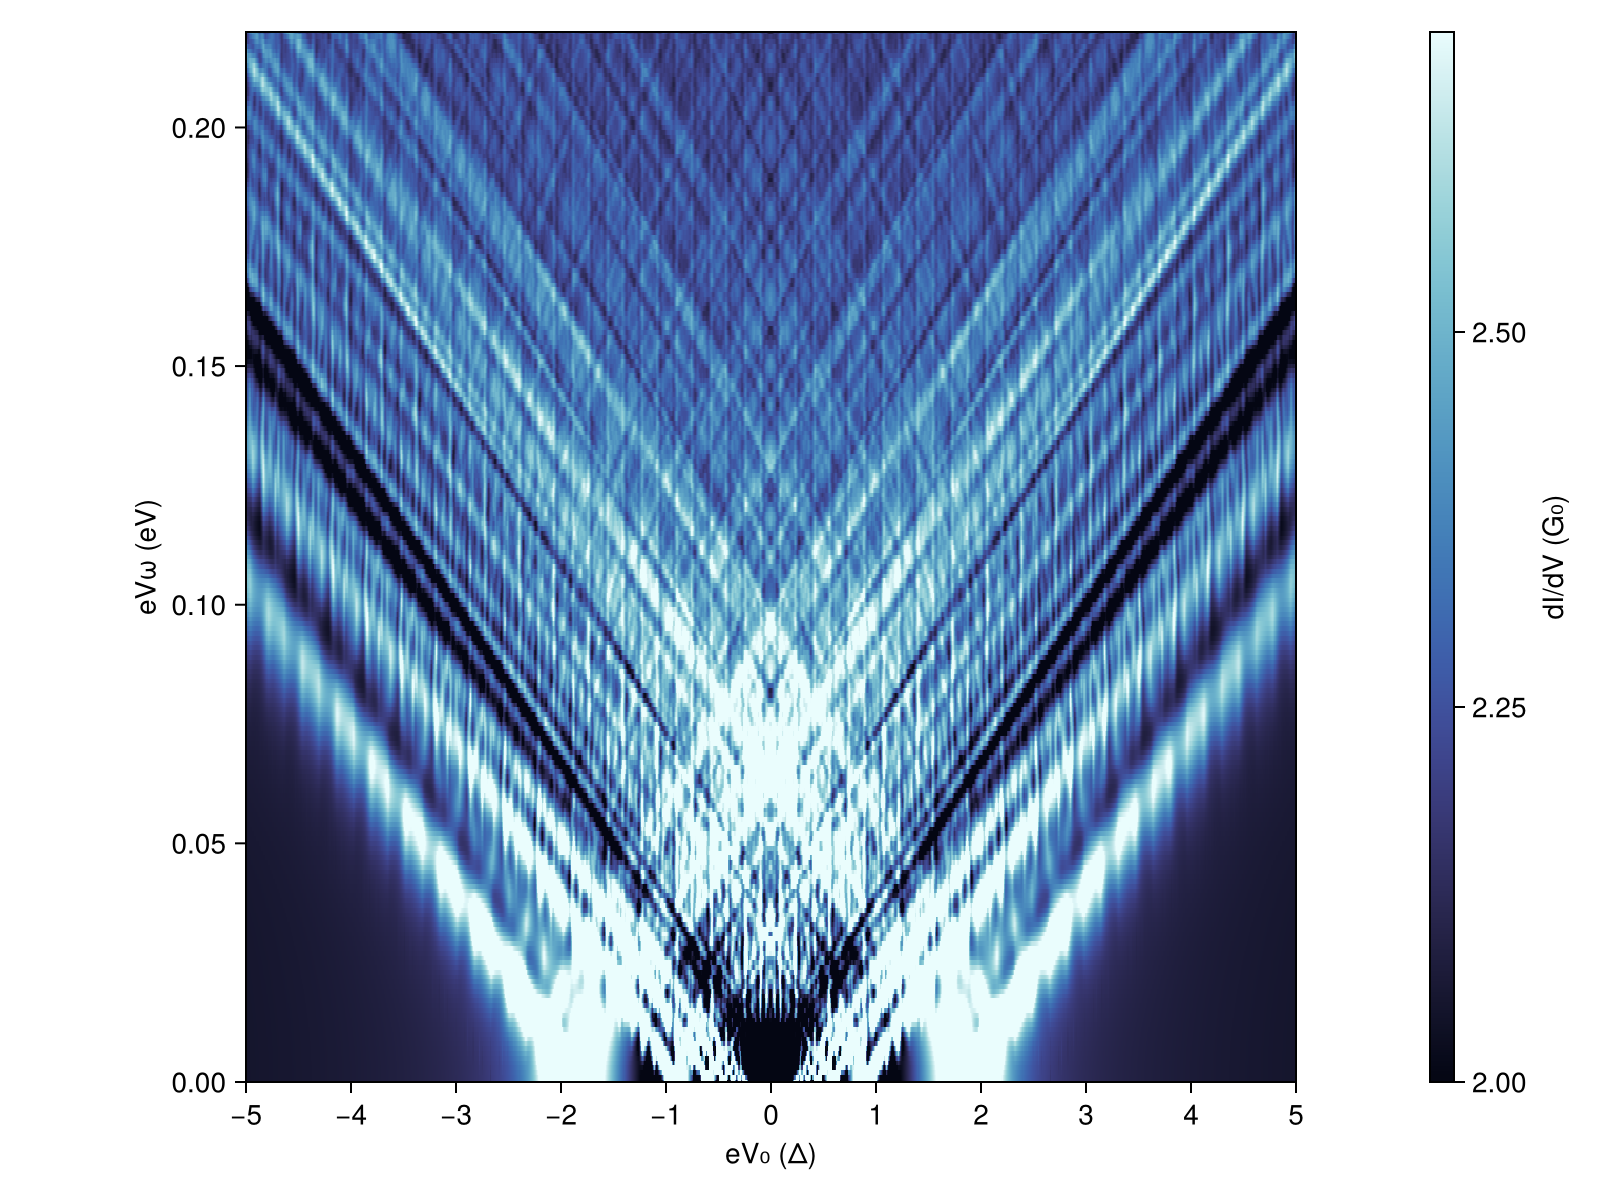

CairoMakie.Screen{IMAGE}


In [22]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1], aspect=1)

plt = heatmap!(ax, V₀[1:end-1], Vω*0.01, dz_sum, colormap=ColorSchemes.ice; colorrange=(2,2.7))
Colorbar(fig[1, 2], plt, label="dI/dV (G₀)")
ax.xlabel = "eV₀ (Δ)"
ax.ylabel = "eVω (eV)"
ax.limits = (-5, 5), (0.0, 0.22)
ax.yticks = 0:0.05:0.2
ax.xticks = round(V₀[1]):1:round(V₀[end])

display(fig)

In [23]:
# save(plotsdir("TG_PAMAR_IV-M$(maximum(TG.m))-G$(sum(τ))G₀.png"), fig)

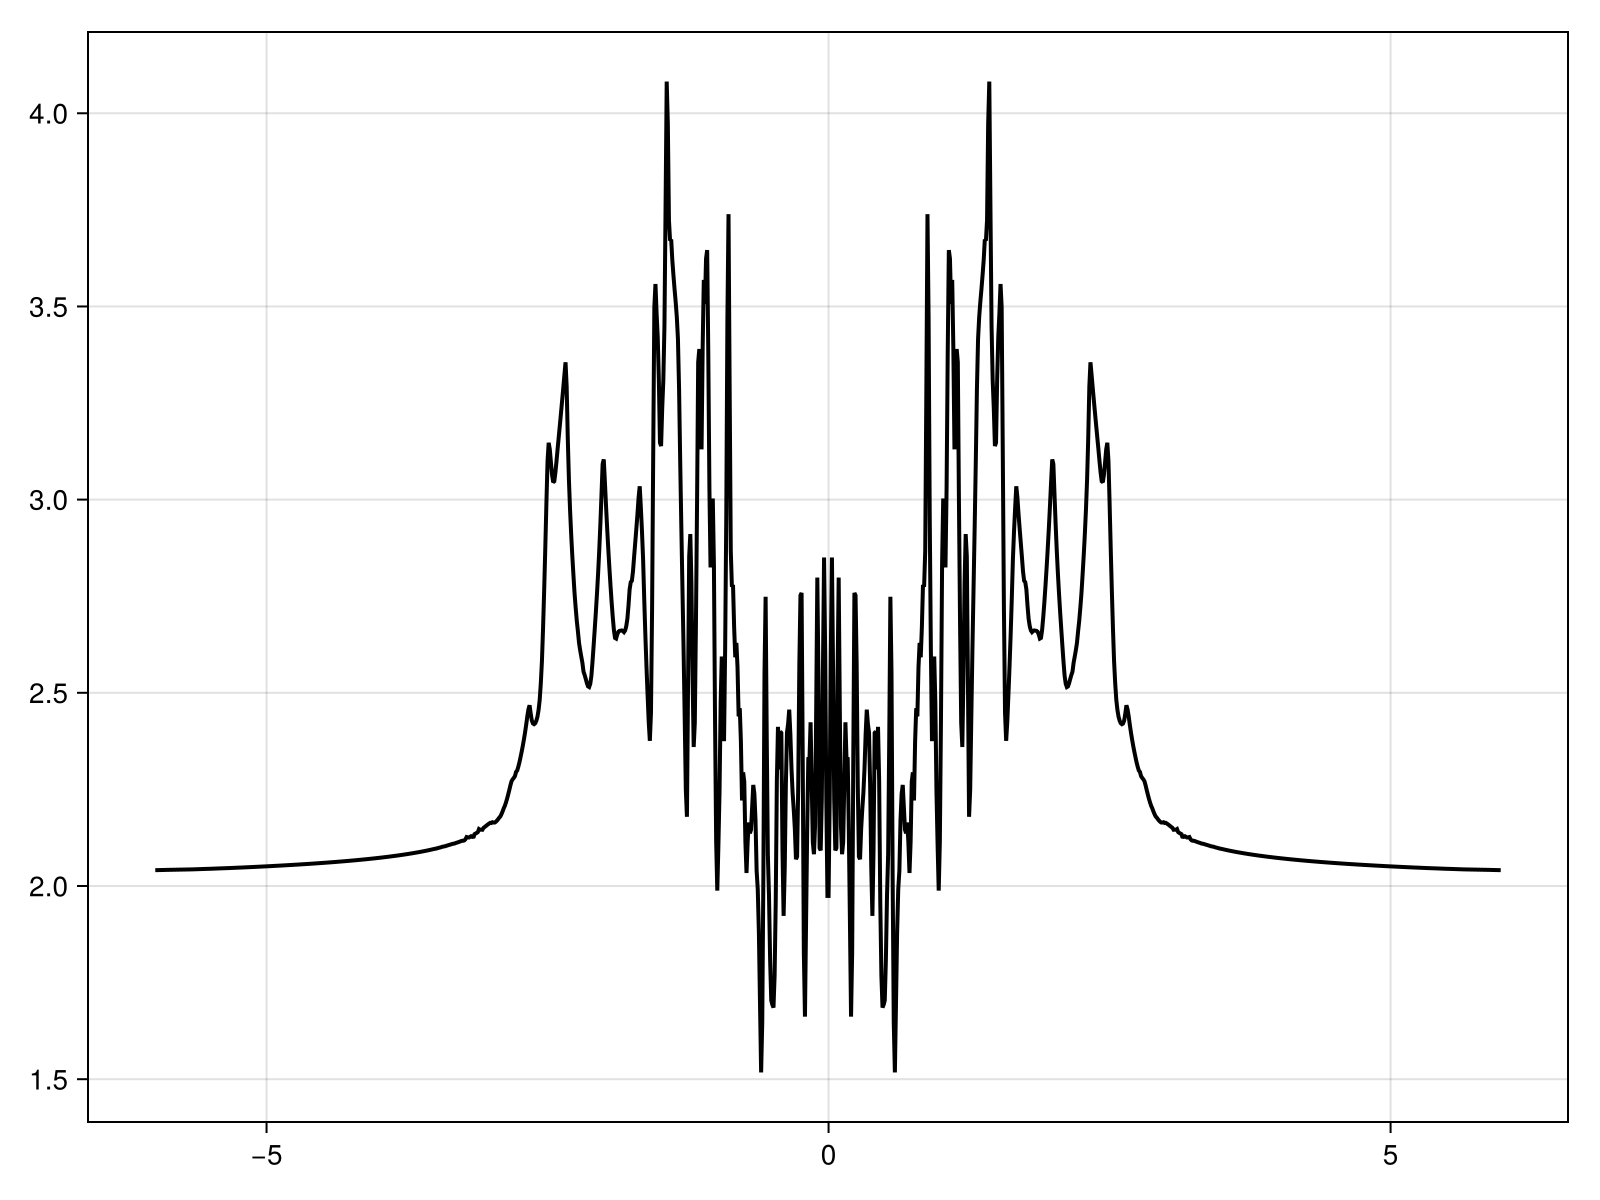

CairoMakie.Screen{IMAGE}


In [26]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1])

evolution = 20

x = V₀[1:end-1]
y = dz_sum[:, evolution]

plt = lines!(ax, x, y, color=:black, linewidth=2)
ax.yticks = 0:0.5:6

display(fig)

In [25]:
# ref_V0, ref_I0 = TG.reference.V0, TG.reference.I0
# # ref_I0 = fixer(ref_I0)

# evolution = 200
# fact = 3

# fig = Figure()

# ax = Axis(fig[1, 1])

# lines!(ax, ref_V0, ref_I0*fact, color = :Blue, label = "Reference")
# lines!(ax, V₀[1:end], z[:, evolution]*fact, color = :Orange, label = "Irradiated")
# axislegend(ax, position=:lt)
# ax.ylabel = "I (2eΔ/h)"
# ax.xlabel = "eV₀ (Δ)"
# xlims!(ax, (-6, 6))
# # ylims!(ax,(-15, 15))
# ax.xgridvisible = false
# ax.ygridvisible = false

# display(fig)

# fig = Figure()

# ax = Axis(fig[1, 1])
# dy = diff(ref_I0) ./ diff(ref_V0)
# lines!(ax, ref_V0[1:end-1], dy, color = :Blue, label = "Reference")
# lines!(ax, V₀[1:end-1], dz[:, evolution], color = :Orange, label = "Irradiated")
# axislegend(ax, position=:lt)
# ax.ylabel = "dI/dV (G₀)"
# ax.xlabel = "eV₀ (Δ)"
# xlims!(ax, (-6, 6))
# ax.xgridvisible = false
# ax.ygridvisible = false

# # Label(fig[0, 1:2], "PAT @ $(Vω[evolution]) (eV)", fontsize=20)
# # Label(fig[0, 1:2], "τ = $(τ)", fontsize=15, padding = (-950, 0, 0, 0))

# # ax = Axis(fig[1, 3])
# # dy = diff(ref_I0)
# # dy2 = abs.(diff(dy))
# # lines!(ax, ref_V0[1:end-2], dy2, color = :Red, label = "Reference")
# # # lines!(ax, V₀[1:end-2], diff(dz[:, evolution]) ./ diff(V₀[1:end-1]), color = :Blue, label = "Irradiated")
# # xlims!(ax, (-6, 6))

# display(fig)